In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def studentpdf(epsilon, nu):
    if nu <= 2: 
        return 0
    return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)

def garch(mu, omega, alpha, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    sigma_squared[0] = omega / (1 - alpha - beta)
    for t in range(1, T):
        sigma_squared[t] = omega + alpha * (returns[t - 1] - mu) ** 2 + beta * sigma_squared[t - 1]
    return sigma_squared

def negative_log_likelihood_garch(parameters, returns):
    mu, omega, alpha, beta, nu = parameters
    sigmasquared = garch(mu, omega, alpha, beta, returns)
    epsilon = (returns - mu) / np.sqrt(sigmasquared + 1e-8)
    ll = -np.log(np.sqrt(sigmasquared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)

In [3]:
def asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    initial_divisor = 1 - beta - alpha_pos / 2 - alpha_neg / 2
    if initial_divisor <= 0:
        initial_divisor = 1  # to prevent division by zero or negative values in the denominator
    sigma_squared[0] = omega / initial_divisor
    for t in range(1, T):
        epsilon_t = (returns[t-1] - mu) / np.sqrt(max(sigma_squared[t-1], 1e-8))  # Ensure denominator is not zero
        shock_effect = alpha_pos * (epsilon_t**2) if epsilon_t >= 0 else alpha_neg * (epsilon_t**2)
        sigma_squared[t] = omega + shock_effect + beta * sigma_squared[t-1]
    return sigma_squared

def neg_log_likelihood_asymmetric_garch(parameters, returns):
    mu, omega, alpha_pos, alpha_neg, beta, nu = parameters
    sigma_squared = asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns)
    epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
    ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)

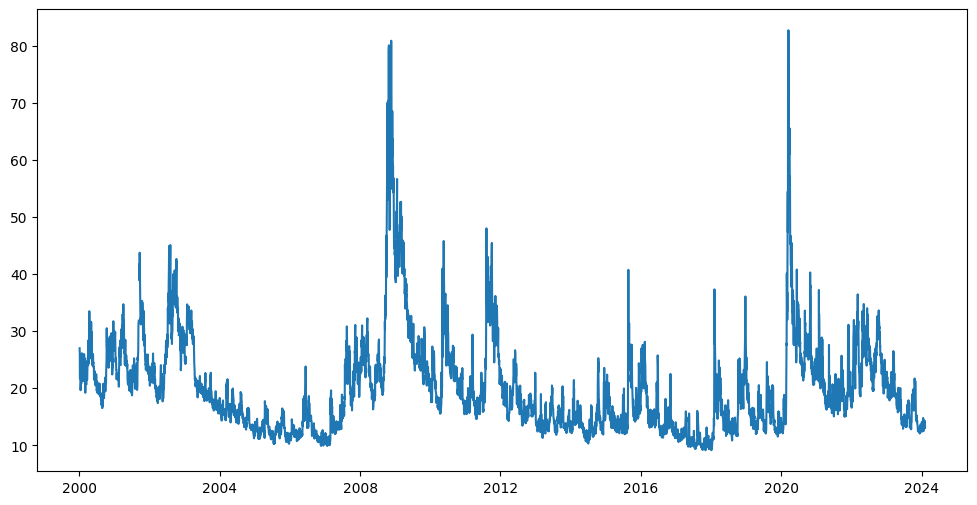

In [4]:
data = pd.read_excel('data.xlsx', index_col='date', parse_dates=True)
returns = data['close-to-close log  return'].values
dates = pd.to_datetime(data.index, format='%Y%m%d')

plt.figure(figsize=(12,6))
plt.plot(data['VIX close']);

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_93604/615677109.py:17: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigmasquared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_93604/615677109.py:18: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigmasquared + 1e-8)) + np.log(studentpdf(epsilon, nu))


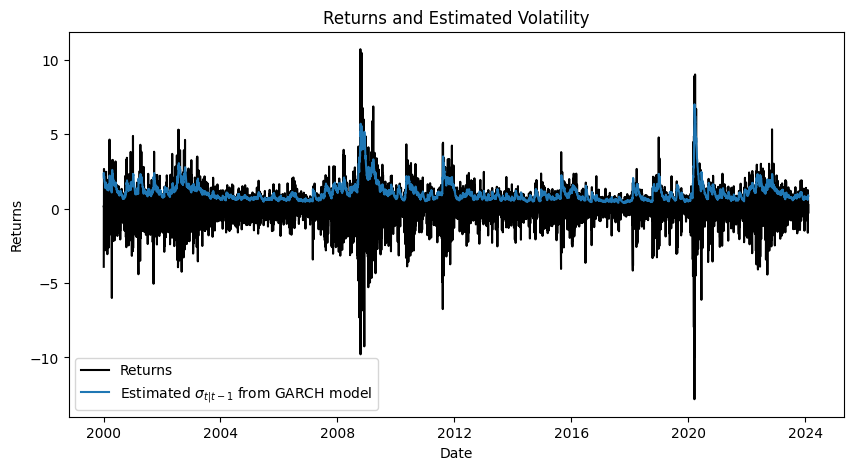

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8211.260819955009
             x: [ 7.559e-02  1.346e-02  1.212e-01  8.757e-01  6.470e+00]
           nit: 307
          nfev: 505
 final_simplex: (array([[ 7.559e-02,  1.346e-02, ...,  8.757e-01,
                         6.470e+00],
                       [ 7.560e-02,  1.346e-02, ...,  8.757e-01,
                         6.470e+00],
                       ...,
                       [ 7.560e-02,  1.346e-02, ...,  8.757e-01,
                         6.470e+00],
                       [ 7.559e-02,  1.346e-02, ...,  8.757e-01,
                         6.470e+00]]), array([ 8.211e+03,  8.211e+03,  8.211e+03,  8.211e+03,
                        8.211e+03,  8.211e+03]))


In [5]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(negative_log_likelihood_garch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat, beta_hat, nu_hat = result.x
sigmasquared = garch(mu_hat, omega_hat, alpha_hat, beta_hat, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), label='Estimated $\sigma_{t|t-1}$ from GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()
print(result)

In [6]:
initial_values = [0.0756, 0.0134, 0.1210, 0.8761, 6.4627]
optimize.minimize(negative_log_likelihood_garch, initial_values, args=(returns,), bounds=bounds)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8211.260922063211
        x: [ 7.560e-02  1.347e-02  1.212e-01  8.757e-01  6.463e+00]
      nit: 7
      jac: [-4.184e-02  6.421e-02  4.475e-02  3.292e-02 -2.910e-02]
     nfev: 72
     njev: 12
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

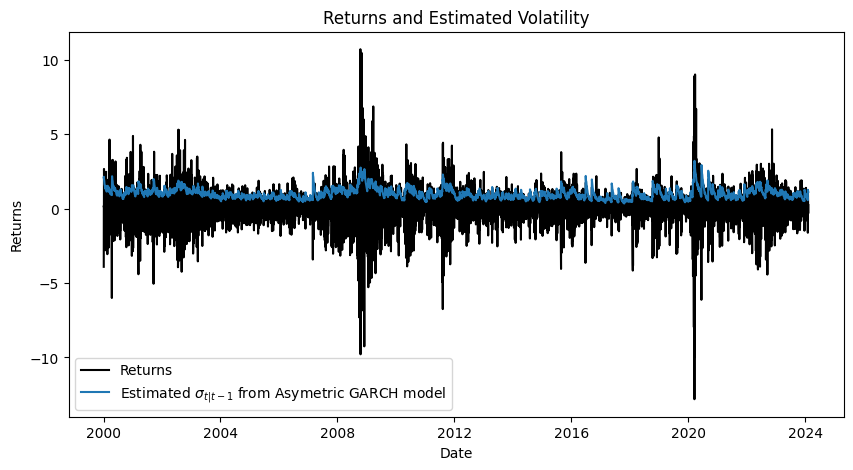

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8304.47740765366
             x: [ 1.621e-02  1.205e-08  7.299e-03  1.571e-01  9.178e-01
                  5.998e+00]
           nit: 472
          nfev: 760
 final_simplex: (array([[ 1.621e-02,  1.205e-08, ...,  9.178e-01,
                         5.998e+00],
                       [ 1.620e-02,  6.032e-08, ...,  9.178e-01,
                         5.998e+00],
                       ...,
                       [ 1.621e-02,  1.351e-07, ...,  9.178e-01,
                         5.998e+00],
                       [ 1.621e-02,  1.286e-07, ...,  9.178e-01,
                         5.998e+00]]), array([ 8.304e+03,  8.304e+03,  8.304e+03,  8.304e+03,
                        8.304e+03,  8.304e+03,  8.304e+03]))


In [7]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.1 , 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(neg_log_likelihood_asymmetric_garch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, nu_hat = result.x
sigmasquared = asymmetric_garch(mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), label='Estimated $\sigma_{t|t-1}$ from Asymetric GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()
print(result)

In [8]:
from arch import arch_model

In [9]:
def symmetric_garch(returns):
    model = arch_model(returns, vol='Garch', p=1, q=1, dist='t')
    res = model.fit(update_freq=5)
    #print(res.summary())
    return res

symmetric_garch(returns)

Iteration:      5,   Func. Count:     42,   Neg. LLF: 8391.626313909504
Iteration:     10,   Func. Count:     76,   Neg. LLF: 8211.591093099949
Iteration:     15,   Func. Count:    106,   Neg. LLF: 8211.524174429309
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8211.52417442931
            Iterations: 15
            Function evaluations: 106
            Gradient evaluations: 15


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -8211.52
Distribution:      Standardized Student's t   AIC:                           16433.0
Method:                  Maximum Likelihood   BIC:                           16466.6
                                              No. Observations:                 6062
Date:                      Wed, May 08 2024   Df Residuals:                     6061
Time:                              15:49:21   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [10]:
def asymmetric_garch(returns):
    model = arch_model(returns, vol='Garch', p=1, o=1, q=1, dist='t')
    res = model.fit(update_freq=5)
    #print(res.summary())
    return res

asymmetric_garch(returns)

Iteration:      5,   Func. Count:     44,   Neg. LLF: 13664.714528013868
Iteration:     10,   Func. Count:     83,   Neg. LLF: 8110.383239295677
Iteration:     15,   Func. Count:    117,   Neg. LLF: 8110.346807110647
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8110.346807110645
            Iterations: 15
            Function evaluations: 117
            Gradient evaluations: 15


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -8110.35
Distribution:      Standardized Student's t   AIC:                           16232.7
Method:                  Maximum Likelihood   BIC:                           16273.0
                                              No. Observations:                 6062
Date:                      Wed, May 08 2024   Df Residuals:                     6061
Time:                              15:49:21   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [ ]:
initial_values = [0.0475, 0.0167, 0.10, 0.1 , 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(neg_log_likelihood_asymmetric_garch, initial_values, args=(returns,), bounds=bounds, method='Nelder-Mead')
